In [1]:
import os
import sys

project_dir = os.path.realpath(os.path.join(os.getcwd(), '..','..','..'))
tool_dir = os.path.join(project_dir, 'Utils')
sys.path.append(tool_dir)

In [2]:
from workers import *
import ta
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [3]:
start_date = '2019-01-01'
end_date = '2021-07-02'
ticker = 'AMZN'
# spy = get_all_price(ticker, start, end)

In [4]:
class technicalIndicator:
    def __init__(self, ticker, start_date, end_date):

        self.ticker = ticker
        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date)
        self.df = get_all_price(self.ticker, self.start_date, self.end_date)

        self.columns = {'open','high','low','close','volume'}
        assert self.columns.issubset(self.df.columns)
        
        self.df = self.df
        self.open = self.df.open
        self.high = self.df.high
        self.low = self.df.low
        self.close = self.df.close
        self.volume = self.df.volume
        self.atr()
        self.rsi()
        
    def run(self, strategy='reversal'):
        if strategy == 'reversal':
            index = self.reversal_functions()
            return self.df[index]
    
    def reversal_functions(self):
        return self.close_minus_open_filter() & \
               self.open_minus_low_filter() & \
               self.volume_filter() & \
               self.neg_cumret_filter() & \
               self.rsi_filter()
    
    #other functionality
    def persistence(self, window=30):
        rolling_high = self.high.rolling(window).max()
        rolling_low = self.low.rolling(window).min()
        
        high_persistence = pd.DataFrame(rolling_high.dropna().drop_duplicates(keep='first'))
        high_persistence['start_date'] = high_persistence.index
        high_persistence['end_date'] = high_persistence['start_date'].shift(-1)
        high_persistence.loc[high_persistence.index[-1], 'end_date'] = self.end_date
        high_persistence['duration'] = high_persistence['end_date'] - high_persistence['start_date']
        sorted_high_persistence = high_persistence.sort_values('duration', ascending=False)
        
        low_persistence = pd.DataFrame(rolling_low.dropna().drop_duplicates(keep='first'))
        low_persistence['start_date'] = low_persistence.index
        low_persistence['end_date'] = low_persistence['start_date'].shift(-1)
        low_persistence.loc[low_persistence.index[-1], 'end_date'] = self.end_date
        low_persistence['duration'] = low_persistence['end_date'] - low_persistence['start_date']
        sorted_low_persistence = low_persistence.sort_values('duration', ascending=False)
        
        return sorted_high_persistence, sorted_low_persistence
        
    #filters
    def close_minus_open_filter(self, k=0.5, strength = 'strong'):
        """
        close - open >= K*atr
        strength = 'strong', 'weak'
        """
        if strength == 'weak':
            index = abs(self.close - self.open) <= k*self.atr
        else:
            index = self.close - self.open >= k*self.atr
        return index
    
    def open_minus_low_filter(self, k=0.5):
        """
        Open - Low >= K*(Close - Open)
        """
        index = self.open - self.low >= k*(self.close-self.open)
        return index

    def volume_filter(self, periods=5):
        """
        Current volume > volume MA 
        """
        lag_volume = self.volume.rolling(periods).mean().shift()
        index = self.volume > lag_volume
        return index

    def neg_cumret_filter(self, periods=5):
        """
        Cumulative return is negative for previous n days
        """
        lag_close = self.close.shift(periods)
        index = self.close < lag_close
        return index
    
    def rsi_filter(self, periods=5, threshold = None):
        """
        Current RSI < min(RSI in the past n days)
        """
        if threshold is None:
            rolling_rsi = self.rsi.rolling(periods).min().shift()
            index = self.rsi < rolling_rsi
        else:
            index = self.rsi <= threshold
        return index
        
    #technical indicators
    def atr(self, n=14):
        data = self.df.copy()
        data['tr0'] = abs(self.high - self.low)
        data['tr1'] = abs(self.high - self.close.shift())
        data['tr2'] = abs(self.low - self.close.shift())
        tr = data[['tr0', 'tr1', 'tr2']].max(axis=1)
        self.atr = self.wwma(tr, n)
    
    def wwma(self, values, n):
        """
        J. Welles Wilder's EMA 
        """
        return values.ewm(alpha=1/n, adjust=False).mean()
    
    def rsi(self):
        self.rsi = ta.momentum.rsi(self.close, window=14)
    
    @classmethod
    def plot_filtered_date(cls, full_df, filtered_df, persistence_df=None):
        assert 'close' in full_df.columns, 'close column missing'
        close = full_df.close
        filtered_date = filtered_df.index
        
        plt.figure(figsize=(10,4))
        plt.plot(close, label='close')
        plt.scatter(filtered_date, close.loc[filtered_date], c='r')
        plt.legend()
        if persistence_df is not None:
            for index, row in persistence_df.iterrows():
                start_date = row['start_date']
                end_date = row['end_date']
                plt.fill_between(close.loc[start_date: end_date].index, close.min(),
                                 close.loc[start_date: end_date].to_numpy(),
                                 color='g', alpha=0.3)

In [5]:
TI = technicalIndicator(ticker, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [6]:
TI.run(strategy='reversal')

,open,high,low,close,adj close,volume
Date,,,,,,


In [7]:
f1 = TI.close_minus_open_filter(0.2, strength = 'weak')
f2 = TI.open_minus_low_filter(0.1)
f3 = TI.volume_filter(5)
f4 = TI.neg_cumret_filter()
f5 = TI.rsi_filter(periods=5, threshold = 40)
filtered = TI.df[f1&f2&f3&f4&f5]

persistence_high, persistence_low = TI.persistence()

In [8]:
persistence_high

,high,start_date,end_date,duration
Date,,,,
2021-04-30,3554.000000,2021-04-30,2021-06-14,45 days
2019-05-03,1964.400024,2019-05-03,2019-06-17,45 days
2020-02-11,2185.949951,2020-02-11,2020-03-25,43 days
2021-02-03,3434.000000,2021-02-03,2021-03-18,43 days
2020-09-02,3552.250000,2020-09-02,2020-10-15,43 days
...,...,...,...,...
2020-04-14,2292.000000,2020-04-14,2020-04-15,1 days
2020-04-13,2180.000000,2020-04-13,2020-04-14,1 days
2020-04-08,2044.000000,2020-04-08,2020-04-09,1 days


Text(0.5, 1.0, 'AMZN reversal pattern')

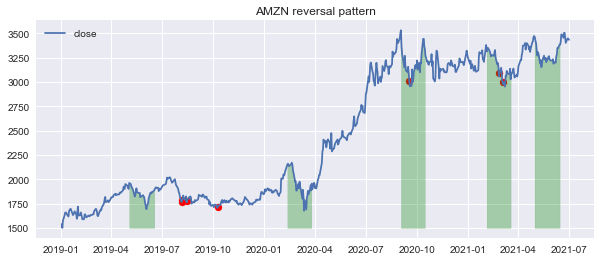

In [9]:
technicalIndicator.plot_filtered_date(TI.df, filtered, persistence_high[:5])
plt.title(ticker + ' reversal pattern')